In [17]:
from nltk.corpus import stopwords
import nltk
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.initializers import Constant

from warnings import filterwarnings
filterwarnings('ignore')

In [16]:
data = pd.read_csv('./Phishing_Email.csv') # https://www.kaggle.com/datasets/team-ai/spam-text-message-classification
data.head()

data.dropna(inplace = True)
data['Phishing'] = LabelEncoder().fit_transform(data['Email Type'])
data['Phishing'] = 1 - data['Phishing']
data = data[['Email Text', 'Phishing']]
data.head()

,Email Text,Phishing
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",0
1,the other side of * galicismos * * galicismo *...,0
2,re : equistar deal tickets are you still avail...,0
3,\nHello I am your hot lil horny toy.\n I am...,1
4,software at incredibly low prices ( 86 % lower...,1


In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\str4ng3\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
# Text preprocessing

stop_words = set(stopwords.words("english"))
data['Email Text'] = data['Email Text'].str.lower()
data['Email Text'] = data['Email Text'].str.replace(r"http\S+|@\S+|#\S+|&\S+", " ", regex=True)
data['Email Text'] = data['Email Text'].str.replace(r"[^a-z\s]", " ", regex=True)
data['Email Text'] = data['Email Text'].str.replace(r"\s{2,}", " ", regex=True)
data['Email Text'] = data['Email Text'].apply(lambda x: ' '.join([w for w in x.split() if w not in stop_words]))

data['Email Text'] = data['Email Text'].str.strip()

data.head()

,Email Text,Phishing
0,disc uniformitarianism sex lang dick hudson ob...,0
1,side galicismos galicismo spanish term names i...,0
2,equistar deal tickets still available assist r...,0
3,hello hot lil horny toy one dream open minded ...,1
4,software incredibly low prices lower drapery s...,1


In [18]:
# Параметри
MAX_WORDS = 20000      # Максимальна кількість слів у словнику
MAX_LEN = 150          # Максимальна довжина повідомлення
EMBEDDING_DIM = 100    # Розмірність вектора 

# Токенізація
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(data['Email Text'])
sequences = tokenizer.texts_to_sequences(data['Email Text'])

# Padding (вирівнювання довжини)
X = pad_sequences(sequences, maxlen=MAX_LEN)
y = data['Phishing'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (14907, 150)
Shape of X_test: (3727, 150)


In [23]:
model_a = Sequential()
model_a.add(Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN))
model_a.add(SpatialDropout1D(0.2))
model_a.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2)) # LSTM шар
model_a.add(Dense(1, activation='sigmoid')) # Вихідний шар для бінарної класифікації

model_a.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("Start training Model A (Custom Embeddings)...")
history_a = model_a.fit(X_train, y_train, 
                        epochs=10, 
                        batch_size=64, 
                        validation_data=(X_test, y_test),
                        verbose=1)

Start training Model A (Custom Embeddings)...
Epoch 1/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.8931 - loss: 0.2543 - val_accuracy: 0.9611 - val_loss: 0.1083
Epoch 2/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.9646 - loss: 0.0942 - val_accuracy: 0.9522 - val_loss: 0.1250
Epoch 3/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.9754 - loss: 0.0621 - val_accuracy: 0.9649 - val_loss: 0.1014
Epoch 4/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9811 - loss: 0.0430 - val_accuracy: 0.9608 - val_loss: 0.1142
Epoch 5/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9820 - loss: 0.0439 - val_accuracy: 0.9606 - val_loss: 0.1209
Epoch 6/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9852 - loss: 0.0329 - val_accuracy: 0.9595 - val_loss: 0.1308
Epoch 7/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.9860 - loss: 0.0284 - val_accuracy: 0.9616 - val_loss: 0.1310
Epoch 8/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/st

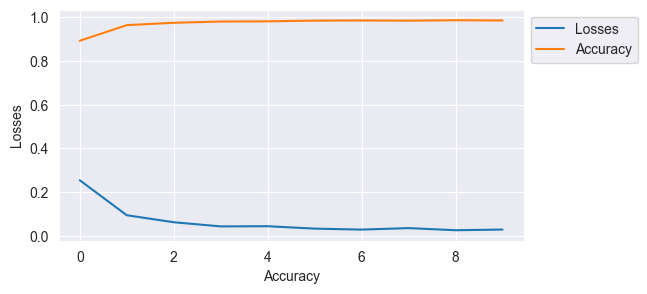

In [24]:
plt.figure(figsize=(6,3))
plt.plot(history_a.history['loss'])
plt.plot(history_a.history['accuracy'])
plt.ylabel('Losses')
plt.xlabel('Accuracy')
plt.legend(['Losses', 'Accuracy'], bbox_to_anchor = (1, 1))
plt.show()

In [25]:
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print(f'Found {len(embeddings_index)} word vectors in GloVe.')

Found 400000 word vectors in GloVe.


In [26]:
word_index = tokenizer.word_index
num_words = min(MAX_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

In [27]:
for word, i in word_index.items():
    if i >= MAX_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Слова, знайдені в GloVe, отримують відповідні вектори
        # Слова, яких немає (наприклад, специфічні спам-терміни), залишаються нулями
        embedding_matrix[i] = embedding_vector

In [29]:
model_b = Sequential()
model_b.add(Embedding(input_dim=num_words, 
                      output_dim=EMBEDDING_DIM, 
                      embeddings_initializer=Constant(embedding_matrix), # Ініціалізація GloVe
                      input_length=MAX_LEN, 
                      trainable=False)) # False = заморозити ваги (не навчати шар ембедінгів)
model_b.add(SpatialDropout1D(0.2))
model_b.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model_b.add(Dense(1, activation='sigmoid'))

model_b.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("Start training Model B (GloVe Embeddings)...")
history_b = model_b.fit(X_train, y_train, 
                        epochs=10, 
                        batch_size=64, 
                        validation_data=(X_test, y_test),
                        verbose=1)

Start training Model B (GloVe Embeddings)...
Epoch 1/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.7414 - loss: 0.5194 - val_accuracy: 0.8565 - val_loss: 0.3445
Epoch 2/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.8415 - loss: 0.3675 - val_accuracy: 0.8903 - val_loss: 0.2646
Epoch 3/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8644 - loss: 0.3233 - val_accuracy: 0.9085 - val_loss: 0.2275
Epoch 4/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.8894 - loss: 0.2661 - val_accuracy: 0.9144 - val_loss: 0.2143
Epoch 5/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9072 - loss: 0.2277 - val_accuracy: 0.9254 - val_loss: 0.1956
Epoch 6/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.9153 - loss: 0.2082 - val_accuracy: 0.9343 - val_loss: 0.1702
Epoch 7/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.9218 - loss: 0.1912 - val_accuracy: 0.9388 - val_loss: 0.1598
Epoch 8/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 12s 5

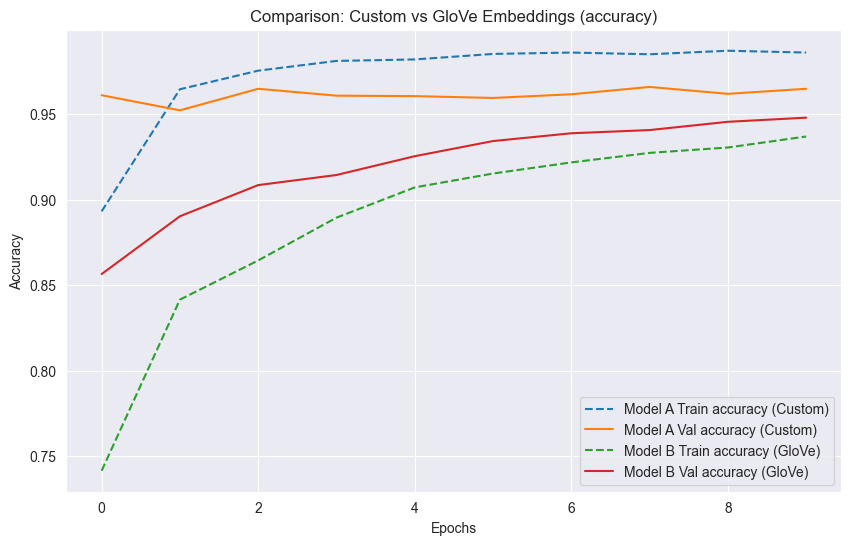

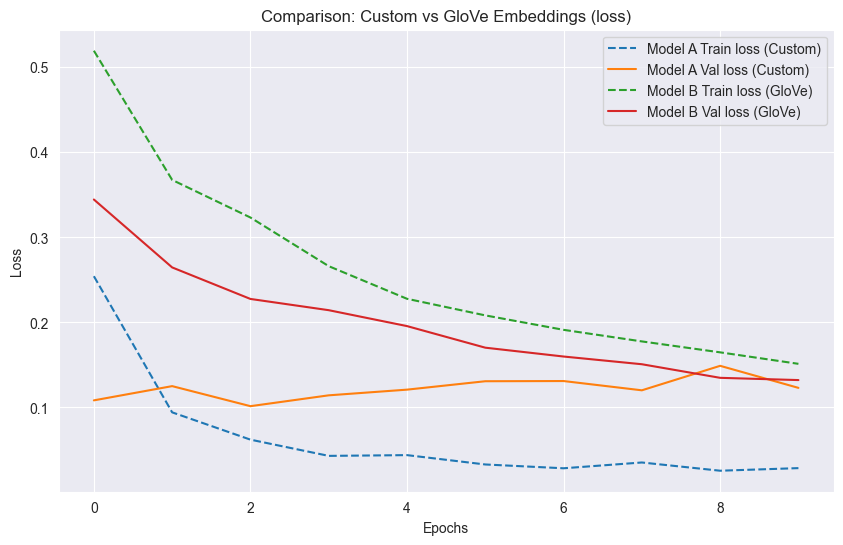

Model A (Custom) Accuracy: 96.49%
Model B (GloVe) Accuracy:  94.79%


In [30]:
def plot_comparison(hist_a, hist_b, metric='accuracy'):
    plt.figure(figsize=(10, 6))
    plt.plot(hist_a.history[metric], label=f'Model A Train {metric} (Custom)', linestyle='--')
    plt.plot(hist_a.history[f'val_{metric}'], label=f'Model A Val {metric} (Custom)')
    
    plt.plot(hist_b.history[metric], label=f'Model B Train {metric} (GloVe)', linestyle='--')
    plt.plot(hist_b.history[f'val_{metric}'], label=f'Model B Val {metric} (GloVe)')
    
    plt.title(f'Comparison: Custom vs GloVe Embeddings ({metric})')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

plot_comparison(history_a, history_b, 'accuracy')
plot_comparison(history_a, history_b, 'loss')

# Фінальна оцінка
loss_a, acc_a = model_a.evaluate(X_test, y_test, verbose=0)
loss_b, acc_b = model_b.evaluate(X_test, y_test, verbose=0)

print(f"Model A (Custom) Accuracy: {acc_a*100:.2f}%")
print(f"Model B (GloVe) Accuracy:  {acc_b*100:.2f}%")